In [2]:
from PIL import Image
from transformers import AutoTokenizer, AutoProcessor, AutoModelForImageTextToText

model_path = "nanonets/Nanonets-OCR-s"

model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype="auto",
    # attn_implementation="flash_attention_2"
)
model.to("mps")
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)
processor = AutoProcessor.from_pretrained(model_path)

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
def ocr_page_with_nanonets_s(image, model, processor, max_new_tokens=4096):
    prompt = """Analyze this product image and extract key information including the product name, brand, category, and model if visible, describe the primary and secondary colors of both the product and background, identify all logos, text, and branding elements with their positions, note the background type and setting whether studio or lifestyle, describe the materials, textures, and key features that are visible, mention any packaging, accessories, or marketing claims present, assess the photography style, lighting, and angle used, and provide observations about the target audience, product condition, and any unique or distinctive elements that stand out in the image."""
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt},
        ]},
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to(model.device)

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]

    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]


In [4]:
import pandas as pd
from hcmus.utils import viz_utils
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageOps

def show_img_from_df(df, idx: int):
    task_id = df[df.index == idx]["task_id"].item()
    x1, y1, x2, y2 = df[df.index == idx]["box"].item()
    path = df[df.index == idx]["path"].item()
    true = df[df.index == idx]["label_str"].item()
    pred = df[df.index == idx]["pred_str"].item()
    img = Image.open(path)
    img = ImageOps.exif_transpose(img)
    img = viz_utils.crop_image(img, [(x1, y1, x2, y2)])[0]
    plt.imshow(img)
    plt.title(f"Task ID: {task_id}\n{true}\n{pred}")

def get_img_from_df(df, idx: int):
    # task_id = df[df.index == idx]["task_id"].item()
    x1, y1, x2, y2 = df[df.index == idx]["box"].item()
    path = df[df.index == idx]["path"].item()
    # true = df[df.index == idx]["label_str"].item()
    # pred = df[df.index == idx]["pred_str"].item()
    img = Image.open(path)
    img = ImageOps.exif_transpose(img)
    img = viz_utils.crop_image(img, [(x1, y1, x2, y2)])[0]
    return img

In [5]:
df = pd.read_parquet("review-2025-07-01.parquet")

In [6]:
df[df["correct"] == False]

,pred,label,task_id,box,path,label_str,pred_str,correct,segment,accuracy
8,30,89,2513,"[1489.6350030327112, 1237.1760865334045, 1535....",/Volumes/Cucumber/Projects/datasets/raw/hcmus-...,8934822361211-bia-heineken-khong-con-lon-330ml,8934822431211-bia-tiger-soju-infused-lager-won...,False,easy,0.853659
9,88,89,2513,"[1079.4122834030575, 9.147380322789534e-15, 12...",/Volumes/Cucumber/Projects/datasets/raw/hcmus-...,8934822361211-bia-heineken-khong-con-lon-330ml,8934822212339-bia-heineken-lon-cao-330ml,False,easy,0.853659
10,88,89,2513,"[1220.1657569979193, 0.0, 1363.799414579526, 1...",/Volumes/Cucumber/Projects/datasets/raw/hcmus-...,8934822361211-bia-heineken-khong-con-lon-330ml,8934822212339-bia-heineken-lon-cao-330ml,False,easy,0.853659
12,26,89,2513,"[1488.4906658490322, 0.0, 1535.9999999999961, ...",/Volumes/Cucumber/Projects/datasets/raw/hcmus-...,8934822361211-bia-heineken-khong-con-lon-330ml,8934822201272-bia-heineken-silver-lon-250ml,False,easy,0.853659
17,13,88,2513,"[314.6159232629548, 1198.9141170790235, 420.59...",/Volumes/Cucumber/Projects/datasets/raw/hcmus-...,8934822212339-bia-heineken-lon-cao-330ml,8935049501718-nuoc-ngot-sprite-lon-320ml,False,easy,0.853659
...,...,...,...,...,...,...,...,...,...,...
5756,77,57,2020,"[2089.976019184653, 0.0, 2329.400479616307, 50...",/Volumes/Cucumber/Projects/datasets/raw/hcmus-...,8934588672118-nuoc-ngot-pepsi-khong-calo-vi-ch...,8936136163314-nuoc-mam-nam-ngu-3-trong-1-750ml,False,hard,0.250000
5757,18,57,2020,"[2329.4004796163067, 0.0, 2518.9448441247, 523...",/Volumes/Cucumber/Projects/datasets/raw/hcmus-...,8934588672118-nuoc-ngot-pepsi-khong-calo-vi-ch...,8997035601321-nuoc-uong-bu-dien-giai-bo-sung-i...,False,hard,0.250000
5758,13,57,2020,"[2523.9328537170263, 0.0, 2678.561151079137, 5...",/Volumes/Cucumber/Projects/datasets/raw/hcmus-...,8934588672118-nuoc-ngot-pepsi-khong-calo-vi-ch...,8935049501718-nuoc-ngot-sprite-lon-320ml,False,hard,0.250000
5759,63,57,2020,"[2638.6570743405264, 0.0, 2863.1175059952034, ...",/Volumes/Cucumber/Projects/datasets/raw/hcmus-...,8934588672118-nuoc-ngot-pepsi-khong-calo-vi-ch...,8934822112332-bia-tiger-lon-cao-330ml-lon,False,hard,0.250000


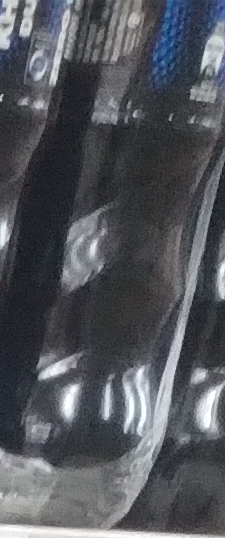

In [12]:
image = get_img_from_df(df, 5759)
image

In [13]:
ocr_page_with_nanonets_s(image, model, processor)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


'The image shows a close-up view of a product, likely a bottle of water, given the context provided by the text "水" (water) in Chinese characters. The product is packaged in a clear plastic bottle with a black label. The label has some text and possibly a logo, but it is not entirely legible due to the angle and lighting.\n\n**Key Information:**\n- **Product Name:** Water\n- **Brand:** Not clearly identifiable from the image.\n- **Category:** Beverage (specifically water)\n- **Model:** Not specified\n\n**Colors:**\n- **Primary Color:** Black (label)\n- **Secondary Color:** Clear (bottle)\n\n**Logos/Text:**\n- There is text on the label, which appears to be in Chinese characters, specifically "水" (water).\n\n**Background:**\n- The background is dark, possibly a table or countertop.\n\n**Materials/Textures:**\n- The bottle is made of clear plastic.\n- The label is printed on a black material, likely paper or vinyl.\n\n**Packaging:**\n- The product is in a single-use plastic bottle.\n\n**